## Importa bibliotecas

In [1]:
import os
import urllib.request
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed = 0
np.random.seed = 0

# Classificação Binária

## Download dataset

In [3]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/two_moons.csv'
data_dir = os.path.abspath(os.path.relpath('../data'))
data_path = os.path.join(data_dir, 'two_moons.csv')
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/2-linear-classification/data/two_moons.csv',
 <http.client.HTTPMessage at 0x7f1a50831898>)

In [4]:
%%bash
head "../data/two_moons.csv"

,x_1,x_2,y
0,2.0644296514467197,0.546069086070731,1.0
1,1.762473261484448,-0.06268920285178106,1.0
2,-0.24548972654900278,1.068868024796405,0.0
3,-0.17463045222800389,0.18388168037297553,1.0
4,0.4521100769674068,-0.40651213749666293,1.0
5,1.9396117132053508,0.43090598314745787,1.0
6,0.898613370647941,0.8226576504874641,0.0
7,0.052218958530233006,1.3636857785600163,0.0
8,-0.6284662881051902,1.1413048711192604,0.0


## Importa dataset

In [5]:
dataset = np.loadtxt(data_path, skiprows=1, usecols=(1,2,3), delimiter=',')

In [6]:
dataset.shape

(1000, 3)

In [7]:
X = dataset[:,0:2]
y = dataset[:,2].astype(int)

In [8]:
mask1 = [i for i, e in enumerate(y) if e]
mask0 = [i for i, e in enumerate(y) if not e]

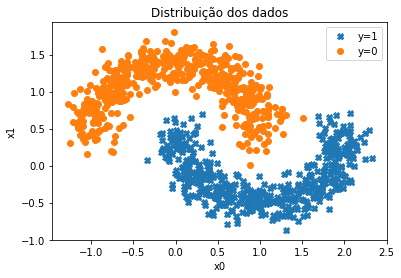

In [11]:
plt.plot(X[mask1, 0], X[mask1,1], 'X')
plt.plot(X[mask0, 0], X[mask0, 1], 'o')
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Distribuição dos dados")
plt.legend(['y=1', 'y=0'])
plt.savefig(os.path.join(image_dir, 'data.png'), bbox_inches='tight')
plt.show()

## Discriminante linear de Fischer

In [12]:
y_hat = lambda w, X: np.dot(w.T, X)

In [13]:
mean_w = lambda w, X: np.dot(w.T, np.mean(X, 0))

In [14]:
sd_w = lambda w, X: np.sum(np.square(y_hat(w, X) - mean_w(w, X)))

In [15]:
s1 =np.sum(np.dot(X[mask1] - np.mean(X[mask1], 0), (X[mask1] - np.mean(X[mask1], 0)).T))

In [20]:
Sw = np.empty((2,2))
mu1 = np.mean(X[mask1], 0)
mu2 = np.mean(X[mask0], 0)
for i in mask1:
    Sw += np.dot((X[i] - mu1).T,(X[i] - mu1))
for i in mask0:
    Sw += np.dot((X[i] - mu2).T,(X[i] - mu2))
Sw

array([[ 640.84629534,  640.84629534],
       [1042.60088757,  919.68629534]])

In [21]:
Sb = np.dot((np.mean(X[mask1], 0) - np.mean(X[mask0],0)),(np.mean(X[mask1], 0) - np.mean(X[mask0],0)).T)

In [22]:
J = lambda w: np.dot(np.dot(w.T, Sb), w)/np.dot(np.dot(w.T, Sw), w)

In [23]:
w = np.dot(np.linalg.inv(Sw),(mu1 - mu2))
w

array([-0.02133727,  0.02290887])

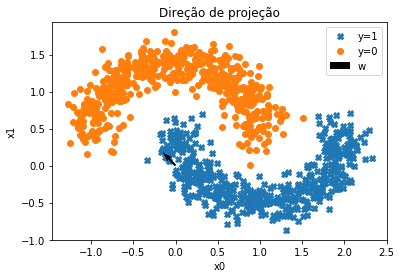

In [26]:
plt.plot(X[mask1, 0], X[mask1,1], 'X', zorder=1)
plt.plot(X[mask0, 0], X[mask0, 1], 'o', zorder=2)


origin = [0], [0] # origin point
plt.xlabel('x0'), plt.ylabel('x1')
plt.title("Direção de projeção")
plt.quiver(*origin, w[0], w[1], width=0.006, color='black', zorder=3)

# w0 = 0
# x = np.linspace(-1.5, 2.5, 1000)
# gx = -(w[0]/w[1])*x - (w[0]/w[1])*w0
# plt.plot(x, gx, 'r', zorder=4)

plt.legend(['y=1', 'y=0', 'w', 'thres = 0'])
plt.savefig(os.path.join(image_dir, 'proj.png'), bbox_inches='tight')
plt.show()

### Projeção em w

In [27]:
proj = lambda X, W: np.dot(X, W)

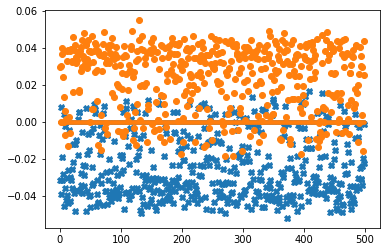

In [29]:
out = proj(X, w)
plt.stem(out[mask1], basefmt='.', linefmt='C0.', markerfmt='C0X')
plt.stem(out[mask0], basefmt='.', linefmt='C1.', markerfmt='C1o')
plt.savefig(os.path.join(image_dir, 'stem_proj.png'), bbox_inches='tight')
plt.show()

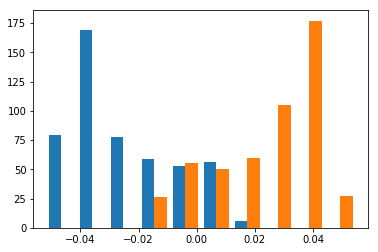

In [30]:
plt.hist([out[mask1], out[mask0]], color=['C0', 'C1'])
plt.show()

In [34]:
def fischer(X, W, thres):
    out = proj(X, W)
    return np.array([1 if e>thres else 0 for e in out])

In [36]:
fischer(X, w, 0)

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,